<h1>模型验证及优化<span class="tocSkip"></span></h1>

模型验证优化主要包括确定评估指标、交叉验证、模型比较、验证结果可视化分析、结果分析和模型调参。<br/>
一般模型选择调优的步骤为：评价指标->验证方式->学习曲线->结果分析->模型选择->模型调参。

In [1]:
import numpy as np  
import pandas as pd
import datetime
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
#########部分SKLearn 集成的算法###############
from sklearn import metrics  
from sklearn import tree
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',10)  
pd.set_option('display.max_rows',20) 

%matplotlib inline

############全局参数#################################
id_col_names=['user_id','coupon_id','date_received']
target_col_name='label'
id_target_cols=['user_id','coupon_id','date_received','label']
myeval='roc_auc'
#cvscore=0

############目录定义#################################
datapath = '../data/' 
featurepath = '../feature/' 
resultpath = '../result/'
tmppath = '../tmp/'
scorepath = '../score/'

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
###########工具函数#############################################
#返回ID列
def get_id_df(df):
    return df[id_col_names]


#返回Target列
def get_target_df(df):
    return df[target_col_name]


#返回特征列
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]


#按特征名读取训练集
def read_featurefile_train(featurename):
    df = pd.read_csv(featurepath + 'train_' + featurename + '.csv',
                     sep=',',
                     encoding="utf-8")
    df.fillna(0, inplace=True)
    return df


#按特征名读取测试集
def read_featurefile_test(featurename):
    df = pd.read_csv(featurepath + 'test_' + featurename + '.csv',
                     sep=',',
                     encoding="utf-8")
    df.fillna(0, inplace=True)
    return df


# 将特征归一化
def standize_df(train_data, test_data):
    from sklearn import preprocessing

    features_columns = [
        f for f in test_data.columns if f not in id_target_cols
    ]
    min_max_scaler = preprocessing.MinMaxScaler()

    train_data_scaler = min_max_scaler.fit_transform(train_data[features_columns])
    test_data_scaler = min_max_scaler.fit_transform(test_data[features_columns])

    train_data_scaler = pd.DataFrame(train_data_scaler)
    train_data_scaler.columns = features_columns

    test_data_scaler = pd.DataFrame(test_data_scaler)
    test_data_scaler.columns = features_columns

    train_data_scaler['label'] = train_data['label']
    train_data_scaler[id_col_names] = train_data[id_col_names]
    test_data_scaler[id_col_names] = test_data[id_col_names]
    return train_data_scaler, test_data_scaler


#按特征名读取数据
def read_data(featurename):
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    #return traindf,testdf
    return standize_df(traindf, testdf)

In [3]:
#数据读取
#所有的特征都是上一节生成的
train_f1, test_f1 = read_data('f1')
#所有的特征都是上一节生成的
train_f2, test_f2 = read_data('sf2')
#所有的特征都是上一节生成的
train_f3, test_f3 = read_data('sf3')

## 评价指标及预测方式

In [4]:
#性能评价函数
#本赛题目标是预测投放的优惠券是否核销。
#针对此任务及一些相关背景知识，使用优惠券核销预测的平均AUC（ROC曲线下面积）作为评价标准。
#即对每个优惠券coupon_id单独计算核销预测的AUC值，再对所有优惠券的AUC值求平均作为最终的评价标准。
# coupon平均auc计算
from sklearn.metrics import roc_auc_score

def myauc(test):
    testgroup = test.groupby(['coupon_id'])
    aucs = []
    for i in testgroup:
        coupon_df = i[1]
        #测算AUC必须大于1个类别
        if len(coupon_df['label'].unique()) < 2:
            continue
        auc = metrics.roc_auc_score(coupon_df['label'], coupon_df['pred'])
        aucs.append(auc)
    return np.average(aucs)

虽然赛题是按照coupon的AUC来计算。不过因为整体AUC（也就是用roc_auc_score 求出的结果）与Coupon AUC同增同减，所以在进行评估的时候可以直接使用整体AUC。<br/>
预测方式，因为要的结果是购买的几率，所以不能直接用Predict因为这样会直接返回0,1,而要用predict_proba，它会返回每个类别的可能行，取其中为1的列即可。

## 验证方式
### 简单交叉验证

In [5]:
# 简单交叉验证F1（随机抽样）
from sklearn.model_selection import train_test_split  # 切分数据
target = get_target_df(train_f1).copy()
traindf = train_f1.copy()

# 切分数据 训练数据80% 验证数据20%
train_all, test_all, train_target, test_target = train_test_split(
    traindf, target, test_size=0.2, random_state=42)

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = LogisticRegression()
clf.fit(train_data, train_target)
train_pred = clf.predict_proba(train_data)[:, 1]
test_pred = clf.predict_proba(test_data)[:, 1]

score_train = metrics.roc_auc_score(train_target, train_pred)
score_test = metrics.roc_auc_score(test_target, test_pred)
print("LogisticRegression train 总体AUC:   ", score_train)
print("LogisticRegression test 总体AUC:   ", score_test)

train_all['pred'] = train_pred
test_all['pred'] = test_pred
print("LogisticRegression train Coupon AUC:   ", myauc(train_all))
print("LogisticRegression test Coupon AUC:   ", myauc(test_all))

LogisticRegression train 总体AUC:    0.664855500345236
LogisticRegression test 总体AUC:    0.6630928317399557
LogisticRegression train Coupon AUC:    0.5371297140333575
LogisticRegression test Coupon AUC:    0.5538079214049014


In [6]:
print(train_target.sum()/train_target.count())
print(test_target.sum()/test_target.count())

0.09203348015451115
0.08961938852582838


In [7]:
# 简单交叉验证F3（随机抽样）
from sklearn.model_selection import train_test_split  # 切分数据

target = get_target_df(train_f3).copy()
traindf = train_f3.copy()

# 切分数据 训练数据80% 验证数据20%
train_all, test_all, train_target, test_target = train_test_split(
    traindf, target, test_size=0.2, random_state=42)

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = LogisticRegression()
clf.fit(train_data, train_target)
train_pred = clf.predict_proba(train_data)[:, 1]
test_pred = clf.predict_proba(test_data)[:, 1]

score_train = roc_auc_score(train_target, train_pred)
score_test = roc_auc_score(test_target, test_pred)
print("LogisticRegression train 总体AUC:   ", score_train)
print("LogisticRegression test 总体AUC:   ", score_test)

train_all['pred'] = train_pred
test_all['pred'] = test_pred
print("LogisticRegression train Coupon AUC:   ", myauc(train_all))
print("LogisticRegression test Coupon AUC:   ", myauc(test_all))

LogisticRegression train 总体AUC:    0.8397681496604559
LogisticRegression test 总体AUC:    0.8426368250072935
LogisticRegression train Coupon AUC:    0.7164199492560941
LogisticRegression test Coupon AUC:    0.7271008836459031


In [8]:
print(train_target.sum()/train_target.count())
print(test_target.sum()/test_target.count())

0.07603585407323725
0.07786932012689139


注意：上面的结果最终都是test的AUC要高于train的AUC，可能原因有：<br/>
（1）数据集太小的话，如果数据集切分的不均匀，或者说训练集和测试集的分布不均匀，如果模型能够正确捕捉到数据内部的分布模式话，这可能造成训练集的内部方差大于验证集，会造成训练集的误差更大。这时你要重新切分数据集或者扩充数据集，使其分布一样。<br/>
（2）模型正则化过多，比如训练时dropout过多，和验证时的模型相差较大，验证时是不会有dropout的。<br/>
（3）训练的精度是每个batch产生的，而验证的精度一般是一个epoch后产生的，验证时的模型是训练一个个batch之后的，有一个的滞后性；可以说训练得差不多的模型用来验证，当然精度要高一点。

上述主要是由于样本分布不均匀导致的：<br/>
采用纯随机的采样方式，这种方式对于大量数据集以及对于目标值分布均匀的情况是可行的。对于分类任务，我们训练一个二值分类器，可能数据中包含大量的正例样本，仅仅包含10%的反例样本，此时的标签分布很不均匀，如果我们通过随机采样的方式，极端情况下可能将正例样本都划分到训练集上，而反例样本恰好都分到测试集，这样训练出来的模型，效果一定不会太好，所以我们需要采用分层采样的方式进行划分数据集，也就是说保证训练集中既包含一定比例的正例样本又要包含一定比例的负例样本。

In [9]:
# 简单交叉验证F1（分层随机抽样）
from sklearn.model_selection import StratifiedShuffleSplit  # 切分数据

target = get_target_df(train_f1).copy()
traindf = train_f1.copy()

# 切分数据 训练数据80% 验证数据20%
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(traindf, target):
    train_all = traindf.loc[train_index]
    train_target = target.loc[train_index]
    test_all = traindf.loc[test_index]
    test_target = target.loc[test_index]

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = LogisticRegression()
clf.fit(train_data, train_target)
train_pred = clf.predict_proba(train_data)[:, 1]
test_pred = clf.predict_proba(test_data)[:, 1]

score_train = metrics.roc_auc_score(train_target, train_pred)
score_test = metrics.roc_auc_score(test_target, test_pred)
print("LogisticRegression train 总体AUC:   ", score_train)
print("LogisticRegression test 总体AUC:   ", score_test)

train_all['pred'] = train_pred
test_all['pred'] = test_pred
print("LogisticRegression train Coupon AUC:   ", myauc(train_all))
print("LogisticRegression test Coupon AUC:   ", myauc(test_all))

LogisticRegression train 总体AUC:    0.664308887617256
LogisticRegression test 总体AUC:    0.6638601261747832
LogisticRegression train Coupon AUC:    0.5394647995244093
LogisticRegression test Coupon AUC:    0.5400207956095779


In [10]:
print(train_target.sum()/train_target.count())
print(test_target.sum()/test_target.count())

0.09154909341685584
0.09155692752290565


In [11]:
# 简单交叉验证F3（分层随机抽样）
from sklearn.model_selection import StratifiedShuffleSplit  # 切分数据

target = get_target_df(train_f3).copy()
traindf = train_f3.copy()

# 切分数据 训练数据80% 验证数据20%
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(traindf, target):
    train_all = traindf.loc[train_index]
    train_target = target.loc[train_index]
    test_all = traindf.loc[test_index]
    test_target = target.loc[test_index]

train_data = get_predictors_df(train_all).copy()
test_data = get_predictors_df(test_all).copy()

clf = LogisticRegression()
clf.fit(train_data, train_target)
train_pred = clf.predict_proba(train_data)[:, 1]
test_pred = clf.predict_proba(test_data)[:, 1]

score_train = metrics.roc_auc_score(train_target, train_pred)
score_test = metrics.roc_auc_score(test_target, test_pred)
print("LogisticRegression train 总体AUC:   ", score_train)
print("LogisticRegression test 总体AUC:   ", score_test)

train_all['pred'] = train_pred
test_all['pred'] = test_pred
print("LogisticRegression train Coupon AUC:   ", myauc(train_all))
print("LogisticRegression test Coupon AUC:   ", myauc(test_all))

LogisticRegression train 总体AUC:    0.8401624524510642
LogisticRegression test 总体AUC:    0.8392721490135375
LogisticRegression train Coupon AUC:    0.7171906886469563
LogisticRegression test Coupon AUC:    0.7315922306904856


In [12]:
print(train_target.sum()/train_target.count())
print(test_target.sum()/test_target.count())

0.07640386612349229
0.07639728872355478


### K折交叉验证 K-fold CV
K折交叉验证： KFold 将所有的样例划分为 k 个组，称为折叠 (fold) （如果 k = n， 这等价于 Leave One Out（留一） 策略），都具有相同的大小（如果可能）。预测函数学习时使用 k - 1 个折叠中的数据，最后一个剩下的折叠会用于测试。

In [13]:
# 5折交叉验证
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
for k, (train_index, test_index) in enumerate(kf.split(train)):
    train_data, test_data, train_target, test_target = train.iloc[
        train_index], train.iloc[test_index], target[train_index], target[
            test_index]
    clf = LogisticRegression()
    clf.fit(get_predictors_df(train_data), train_target)

    train_pred = clf.predict_proba(get_predictors_df(train_data))[:, 1]
    test_pred = clf.predict_proba(get_predictors_df(test_data))[:, 1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred'] = train_pred
    test_data['pred'] = test_pred
    print(k + 1, " 折", "LogisticRegression train 总体AUC:   ", score_train)
    print(k + 1, " 折", "LogisticRegression test 总体AUC:   ", score_test)
    print(k + 1, " 折", "LogisticRegression train Coupon AUC:   ", myauc(train_data))
    print(k + 1, " 折", "LogisticRegression test Coupon AUC:   ", myauc(test_data), '\n')

1  折 LogisticRegression train 总体AUC:    0.8330477476356697
1  折 LogisticRegression test 总体AUC:    0.8683972587488785
1  折 LogisticRegression train Coupon AUC:    0.7114559568788156
1  折 LogisticRegression test Coupon AUC:    0.7251598500317984 

2  折 LogisticRegression train 总体AUC:    0.8331516430725072
2  折 LogisticRegression test 总体AUC:    0.8649730424625975
2  折 LogisticRegression train Coupon AUC:    0.7145694335559735
2  折 LogisticRegression test Coupon AUC:    0.7162330353981553 

3  折 LogisticRegression train 总体AUC:    0.84433185047919
3  折 LogisticRegression test 总体AUC:    0.8209095516363233
3  折 LogisticRegression train Coupon AUC:    0.720120242277777
3  折 LogisticRegression test Coupon AUC:    0.7228972032906389 

4  折 LogisticRegression train 总体AUC:    0.8454061094994901
4  折 LogisticRegression test 总体AUC:    0.8168713267119359
4  折 LogisticRegression train Coupon AUC:    0.7097917580768762
4  折 LogisticRegression test Coupon AUC:    0.7415823871476624 

5  折 LogisticRegres

### 留P法 LPO CV
留一交叉验证： LeaveOneOut (或 LOO) 是一个简单的交叉验证。每个学习集都是通过除了一个样本以外的所有样本创建的，测试集是被留下的样本。 因此，对于 n 个样本，我们有 n 个不同的训练集和 n 个不同的测试集。这种交叉验证程序不会浪费太多数据，因为只有一个样本是从训练集中删除掉的<br/>

留P交叉验证： LeavePOut 与 LeaveOneOut 非常相似，因为它通过从整个集合中删除 p 个样本来创建所有可能的 训练/测试集。对于 n 个样本，这产生了 {n \choose p} 个 训练-测试 对。**LeaveOneOut 和 KFold 不同，当 p > 1 时，测试集会重叠**。

In [14]:
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import LeavePOut
lpo = LeavePOut(p=200)
num = 100
for k, (train_index, test_index) in enumerate(lpo.split(train)):
    train_data, test_data, train_target, test_target = train.iloc[
        train_index], train.iloc[test_index], target[train_index], target[
            test_index]
    clf = LogisticRegression()
    clf.fit(get_predictors_df(train_data), train_target)

    train_pred = clf.predict_proba(get_predictors_df(train_data))[:, 1]
    test_pred = clf.predict_proba(get_predictors_df(test_data))[:, 1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred'] = train_pred
    test_data['pred'] = test_pred
    print(k + 1, " 折", "LogisticRegression train 总体AUC:   ", score_train)
    print(k + 1, " 折", "LogisticRegression test 总体AUC:   ", score_test)
    print(k + 1, " 折", "LogisticRegression train Coupon AUC:   ",
          myauc(train_data))
    print(k + 1, " 折", "LogisticRegression test Coupon AUC:   ",
          myauc(test_data), '\n')
    if k >= 5:
        break

1  折 LogisticRegression train 总体AUC:    0.840155111392265
1  折 LogisticRegression test 总体AUC:    0.8765514184397163
1  折 LogisticRegression train Coupon AUC:    0.7128813242218235
1  折 LogisticRegression test Coupon AUC:    0.6578947368421053 

2  折 LogisticRegression train 总体AUC:    0.8402230671740365
2  折 LogisticRegression test 总体AUC:    0.8778812056737588
2  折 LogisticRegression train Coupon AUC:    0.7130975302589041
2  折 LogisticRegression test Coupon AUC:    0.675 

3  折 LogisticRegression train 总体AUC:    0.8401036286962222
3  折 LogisticRegression test 总体AUC:    0.8769946808510638
3  折 LogisticRegression train Coupon AUC:    0.7124473896509698
3  折 LogisticRegression test Coupon AUC:    0.631578947368421 

4  折 LogisticRegression train 总体AUC:    0.8402346210132577
4  折 LogisticRegression test 总体AUC:    0.8792109929078014
4  折 LogisticRegression train Coupon AUC:    0.7131071670508777
4  折 LogisticRegression test Coupon AUC:    0.6578947368421053 

5  折 LogisticRegression train 总

### StratifiedKFold
通过比较发现还是StratifiedKFold比较适合本赛题。因为本赛题正负样本分布不均匀。而StratifiedKFold 分层采样交叉切分，确保训练集，测试集中各类别样本的比例与原始数据集中相同。

In [15]:
# 5折交叉验证
train = train_f3.copy()
target = get_target_df(train_f3).copy()

from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate(kf.split(train, target)):
    train_data, test_data, train_target, test_target = train.iloc[
        train_index], train.iloc[test_index], target[train_index], target[
            test_index]
    clf = LogisticRegression()
    clf.fit(get_predictors_df(train_data), train_target)

    train_pred = clf.predict_proba(get_predictors_df(train_data))[:, 1]
    test_pred = clf.predict_proba(get_predictors_df(test_data))[:, 1]
    score_train = roc_auc_score(train_target, train_pred)
    score_test = roc_auc_score(test_target, test_pred)
    train_data['pred'] = train_pred
    test_data['pred'] = test_pred
    print(k + 1, " 折", "训练集正样本占比为 ", train_target.sum()/train_target.count(), 
          "测试集正样本占比为 ",test_target.sum()/test_target.count())
    print(k + 1, " 折", "LogisticRegression train 总体AUC:   ", score_train)
    print(k + 1, " 折", "LogisticRegression test 总体AUC:   ", score_test)
    print(k + 1, " 折", "LogisticRegression train Coupon AUC:   ",
          myauc(train_data))
    print(k + 1, " 折", "LogisticRegression test Coupon AUC:   ",
          myauc(test_data), '\n')

1  折 训练集正样本占比为  0.07640101331690116 测试集正样本占比为  0.07640869981970468
1  折 LogisticRegression train 总体AUC:    0.8334219943143084
1  折 LogisticRegression test 总体AUC:    0.8661577413429687
1  折 LogisticRegression train Coupon AUC:    0.7153486555384969
1  折 LogisticRegression test Coupon AUC:    0.7200170910771825 

2  折 训练集正样本占比为  0.07640364815866124 测试集正样本占比为  0.07639816051031004
2  折 LogisticRegression train 总体AUC:    0.8336627188196837
2  折 LogisticRegression test 总体AUC:    0.8668170323937642
2  折 LogisticRegression train Coupon AUC:    0.7114151037512919
2  折 LogisticRegression test Coupon AUC:    0.7277546091351296 

3  折 训练集正样本占比为  0.07640364815866124 测试集正样本占比为  0.07639816051031004
3  折 LogisticRegression train 总体AUC:    0.8436483111789691
3  折 LogisticRegression test 总体AUC:    0.8265614414455777
3  折 LogisticRegression train Coupon AUC:    0.7158488232906889
3  折 LogisticRegression test Coupon AUC:    0.7238334550841277 

4  折 训练集正样本占比为  0.07640364815866124 测试集正样本占比为  0.076398160510

## 模型比较
### 线下评测分数
选定StratifiedKFold后我们可以直接用上面的方法对不同模型进行比对。也可以sklearn.model_selection.cross_val_score函数。它在cv是整数，而且目标是类别的时候也是用的StratifiedKFold。具体看：
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
不过本赛题因为评测指标是按Coupon的AUC，所以不能用它，要自己计算。

In [16]:
####################使用sklearn的统一代码框架##########################
#提供的函数包括：
#classifier_single(featurename,classifier,cvnum)
#按满减情况分别预测
#classifier_single_sep_fd(featurename,classifier,cvnum):
####################整合在sklearn的分类算法###############
def get_sklearn_model(model_name, param=None):
    #朴素贝叶斯
    if model_name == 'NB':
        model = MultinomialNB(alpha=0.01)
    #逻辑回归
    elif model_name == 'LR':
        model = LogisticRegression(penalty='l2')
    # KNN
    elif model_name == 'KNN':
        model = KNeighborsClassifier()
    #随机森林
    elif model_name == 'RF':
        model = RandomForestClassifier()
    #决策树
    elif model_name == 'DT':
        model = tree.DecisionTreeClassifier()
    #向量机
    elif model_name == 'SVC':
        model = SVC(kernel='rbf')
    #GBDT
    elif model_name == 'GBDT':
        model = GradientBoostingClassifier()
    #XGBoost
    elif model_name == 'XGB':
        model = XGBClassifier()
    #lightGBM
    elif model_name == 'LGB':
        model = LGBMClassifier()
    else:
        print("wrong model name!")
        return
    if param is not None:
        model.set_params(**param)
    return model


#对算法进行分析
def classifier_df_score(train_feat, classifier, cvnum, param=None):
    clf = get_sklearn_model(classifier, param)
    train = train_feat.copy()
    target = get_target_df(train_feat).copy()
    kf = StratifiedKFold(n_splits=cvnum)

    scores = []
    score_coupons = []
    for k, (train_index, test_index) in enumerate(kf.split(train, target)):
        train_data, test_data, train_target, test_target = train.iloc[
            train_index], train.iloc[test_index], target[train_index], target[
                test_index]
        clf.fit(get_predictors_df(train_data), train_target)
        train_pred = clf.predict_proba(get_predictors_df(train_data))[:, 1]
        test_pred = clf.predict_proba(get_predictors_df(test_data))[:, 1]

        score_test = roc_auc_score(test_target, test_pred)
        test_data['pred'] = test_pred
        score_coupon_test = myauc(test_data)

        scores.append(round(score_test,4))
        score_coupons.append(round(score_coupon_test,4))

    print(classifier + "总体AUC:", scores)
    print(classifier + "Coupon AUC:", score_coupons)

In [17]:
#f1特征
train = train_f1.copy()
train.head()

,discount_rate,distance,if_fd,full_value,reduction_value,label,user_id,coupon_id,date_received
0,0.812785,0.1,1.0,0.500000,0.20,0,1439408,11002,20160528
1,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160613
2,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160516
3,0.761035,0.0,1.0,0.100000,0.05,0,2029232,1532,20160530
4,0.939117,0.0,1.0,0.066667,0.01,0,2029232,12737,20160519


In [18]:
print('特征f1, 不同模型5折训练Score：')
classifier_df_score(train, 'NB', 5)
classifier_df_score(train, 'LR', 5)
classifier_df_score(train, 'RF', 5)
classifier_df_score(train, 'LGB', 5)

特征f1, 不同模型5折训练Score：
NB总体AUC: [0.6484, 0.6538, 0.6574, 0.6504, 0.6634]
NBCoupon AUC: [0.5364, 0.5338, 0.5335, 0.5415, 0.5385]
LR总体AUC: [0.663, 0.661, 0.6641, 0.6626, 0.6707]
LRCoupon AUC: [0.5364, 0.5338, 0.5335, 0.5415, 0.5385]
RF总体AUC: [0.6842, 0.684, 0.6847, 0.682, 0.6867]
RFCoupon AUC: [0.5297, 0.527, 0.5199, 0.5302, 0.5371]
LGB总体AUC: [0.6853, 0.6852, 0.6855, 0.683, 0.6888]
LGBCoupon AUC: [0.5332, 0.5264, 0.5266, 0.5324, 0.5405]


In [19]:
#f2特征
train = train_f2.copy()
train.head()

,discount_rate,distance,if_fd,full_value,reduction_value,...,user_merchant_common_buy_rate,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,...,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,...,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,...,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,...,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,...,0.0,0,4061024,9871,20160409


In [20]:
print('特征f2, 不同模型5折训练Score：')
classifier_df_score(train, 'NB', 5)
classifier_df_score(train, 'LR', 5)
classifier_df_score(train, 'RF', 5)
classifier_df_score(train, 'LGB', 5)

特征f2, 不同模型5折训练Score：
NB总体AUC: [0.8221, 0.8041, 0.7474, 0.7364, 0.7399]
NBCoupon AUC: [0.6307, 0.6121, 0.6074, 0.6123, 0.6025]
LR总体AUC: [0.8381, 0.8333, 0.7837, 0.773, 0.7758]
LRCoupon AUC: [0.6294, 0.624, 0.6095, 0.6104, 0.6071]
RF总体AUC: [0.7931, 0.7881, 0.7719, 0.7782, 0.7915]
RFCoupon AUC: [0.5866, 0.5412, 0.5281, 0.5546, 0.5605]
LGB总体AUC: [0.8747, 0.8741, 0.8476, 0.8409, 0.8435]
LGBCoupon AUC: [0.6357, 0.5926, 0.6031, 0.6113, 0.6068]


In [21]:
#f3特征
train = train_f3.copy()
train.head()

,discount_rate,distance,if_fd,full_value,reduction_value,...,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,...,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,...,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,...,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,...,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,...,0.0,0,4061024,9871,20160409


In [22]:
print('特征f3, 不同模型5折训练Score：')
classifier_df_score(train, 'NB', 5)
classifier_df_score(train, 'LR', 5)
classifier_df_score(train, 'RF', 5)
classifier_df_score(train, 'LGB', 5)

特征f3, 不同模型5折训练Score：
NB总体AUC: [0.8536, 0.8388, 0.7909, 0.7804, 0.7833]
NBCoupon AUC: [0.7132, 0.7057, 0.707, 0.714, 0.7066]
LR总体AUC: [0.8662, 0.8668, 0.8266, 0.8166, 0.8165]
LRCoupon AUC: [0.72, 0.7278, 0.7238, 0.7431, 0.7314]
RF总体AUC: [0.8561, 0.8594, 0.8464, 0.8457, 0.8497]
RFCoupon AUC: [0.715, 0.7009, 0.6999, 0.7258, 0.727]
LGB总体AUC: [0.9017, 0.9034, 0.8862, 0.8812, 0.8828]
LGBCoupon AUC: [0.7441, 0.7412, 0.7498, 0.7679, 0.7631]


通过对比训练集上不同算法的运算结果可以发现，F1特征集因为特征比较少，有严重的欠拟合，所以所有算法的分数都比较低。
F2特征集通过滑窗增加统计特征，它的分数比f1有了飞跃性的提高，其实在现实的业务场景F2+LR已经是一个很常用的解决方案了。之所以在实际作业中更倾向逻辑回归而不是类似LightGBM的算法，是为了减少计算量。当然如果计算资源不是问题的话，LightGBM也是一个好选择

### 验证结果可视化分析
将验证结果可视化主要通过绘制**学习曲线**和**验证曲线**来实现。<br/>
（1）学习曲线就是通过画出不同大小训练集和交叉验证的准确率，观察模型在新数据上的表现来**判断模型是否存在方差过高或偏差过高，以及增大训练集是否可以减少过拟合等**。<br/>
（2）验证曲线和学习曲线的区别：横轴为某个**超参数**的一系列值，由此来看是不同参数设置下的准确率，而不是不同训练集大小下的准确率。从验证曲线上可以看到，随着超参数设置的改变，模型可能会有从欠拟合到合适再到过拟合的过程，进而可以选择一个合适设置来提高模型的性能。

In [23]:
#画学习曲线
def plot_learning_curve(estimator,
                        title,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=1,
                        train_sizes=[0.01, 0.02, 0.05, 0.1, 0.2, 0.3]):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=myeval,
        n_jobs=n_jobs,
        train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt


#画算法的学习曲线,为加快画图速度，最多选20%数据
def plot_curve_single(traindf,
                      classifier,
                      cvnum,
                      train_sizes=[0.01, 0.02, 0.05, 0.1, 0.2, 0.3]):
    X = get_predictors_df(traindf)
    y = get_target_df(traindf)
    title = "learning curve of " + classifier + ", cv:" + str(cvnum)
    estimator = get_sklearn_model(classifier)  #建模
    plot_learning_curve(estimator,
                        title,
                        X,
                        y,
                        ylim=(0, 1.01),
                        cv=cvnum,
                        train_sizes=train_sizes)

#### F1特征集

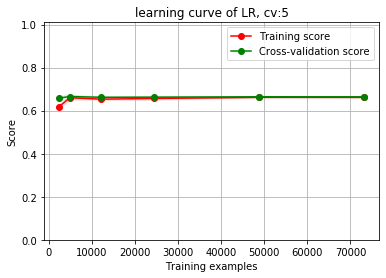

In [24]:
plot_curve_single(train_f1, "LR", 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

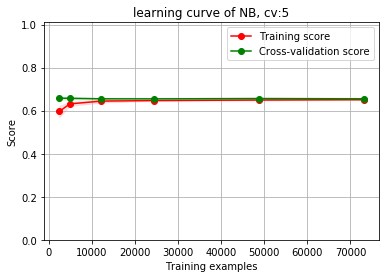

In [25]:
plot_curve_single(train_f1, "NB", 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

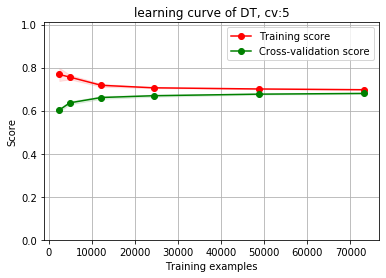

In [26]:
plot_curve_single(train_f1, "DT", 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

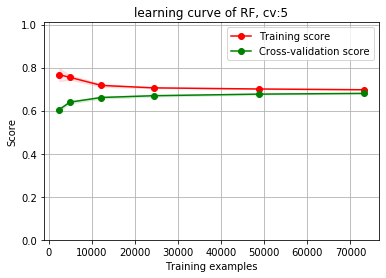

In [27]:
plot_curve_single(train_f1, "RF", 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

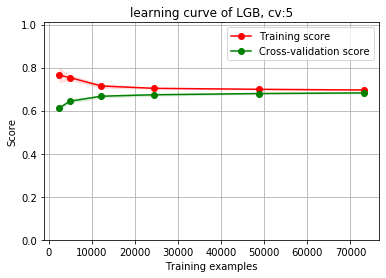

In [28]:
plot_curve_single(train_f1, "LGB", 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

#### F2特征集

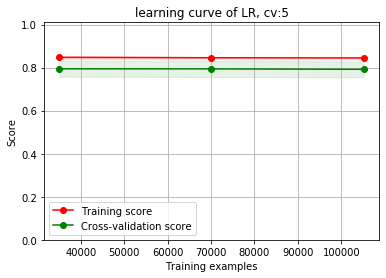

In [29]:
plot_curve_single(train_f2, "LR", 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

在03_model_training中已经展示过学习曲线绘制<br/>
可以发现在特征集f1上，评测分普遍比较低，是欠拟合。<br/>
在特征集f3上决策树和随机森林都表现出过拟合。LGB表现比较好。

# 模型超参空间及调参

超参数是在开始学习之前设置值的参数，而不是通过训练得到的参数。在通常青果下，在机器学习过程中需要对超参数进行优化，给学习器选择一组最优超参数，以提高学习的性能和效果。比如，树的数量或深度、学习率（多种模式）及K均值聚类中的簇数等都是超参数。

与超参数区别的概念是参数，它是模型训练过程中学习到的一部分，比如回归系数、神经网络权重等。

简而言之，超参数是人工配置的（本质上是参数的参数，每次改变超参数模型都要重新训练），参数是训练获得的。

常见的超参数搜索算法有**网格搜索**、**随机搜索**、**启发式搜索**

In [30]:
#f3
train = get_predictors_df(train_f3)
target = get_target_df(train_f3)
train.head()

,discount_rate,distance,if_fd,full_value,reduction_value,...,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after
0,0.863014,0.0,1.0,0.666667,0.20,...,0.0,0.0,0.0,0.0,0.0
1,0.786910,1.0,1.0,0.666667,0.30,...,0.0,0.0,0.0,0.0,0.0
2,0.863014,0.2,1.0,0.666667,0.20,...,0.0,0.0,0.0,0.0,0.0
3,0.863014,1.0,1.0,0.666667,0.20,...,0.0,0.0,0.0,0.0,0.0
4,0.761035,1.0,1.0,0.100000,0.05,...,0.0,0.0,0.0,0.0,0.0


## 网格搜索

网格搜索是在所有候选的参数选项中进行循环遍历，尝试每一种可能性，表现最好的参数就是最终的结果（暴力搜索）。

原理：在一定区间内，通过循环遍历尝试每一种可能性，并计算其约束函数和目标函数的值。对满足约束条件的点，逐个比较其目标函数的值，抛弃坏的点，保留好的点，最后得到最优解的近似解。为了避免初始数据的划分对结果的影响，一般情况下网格搜索需要和交叉验证结合使用。

sklearn()函数定义：<br/>
*class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=None, iid='warn', refit=True, cv='warn', verbose=0, pre_dispatch='2*n_jobs', error_score='raise=deprecating', return_train_score='warn')*

#### 随机森林模型为例采用网格调参

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit  # 切分数据

# 切分数据 训练数据80% 验证数据20%
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train, target):
    train_data = train.loc[train_index]
    train_target = target.loc[train_index]
    test_data = train.loc[test_index]
    test_target = target.loc[test_index]

model = RandomForestClassifier()
parameters = {'n_estimators': [20, 50, 100], 'max_depth': [1, 2, 3]}

clf = GridSearchCV(model, parameters, cv=3, verbose=2)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict(test_data))

print("RandomForestClassifier GridSearchCV test AUC:   ", score_test)
print("最优参数:")
print(clf.best_params_)
sorted(clf.cv_results_.keys())

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=1, n_estimators=20 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=1, n_estimators=20, total=   1.1s
[CV] max_depth=1, n_estimators=20 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ..................... max_depth=1, n_estimators=20, total=   1.1s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   1.0s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   2.1s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   2.0s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   1.8s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   3.7s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   3.9s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.3min finished


RandomForestClassifier GridSearchCV test AUC:    0.5298280412375206
最优参数:
{'max_depth': 3, 'n_estimators': 100}


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

运行起来我们可以发现网格搜索很耗时间，每次训练及预测的次数是按照参数的个数指数增长的。所以一次不要搜索太多的参数，一般1，2个就可以了。

## 随机搜索

随机搜索是利用随机数去求函数近似最优解的方法，区别于网格搜索的暴力搜索。

原理：在一定区间内，不断地、随机地而不是有倾向性地产生随机点，并计算其约束函数和目标函数的值。对满足约束条件的点，逐个比较其目标函数的值，抛弃坏的点，保留好的点，最后得到最优解的近似解。随机搜索建立在概率论的基础上，所取随机点越多，得到最优解的概率也就越大。这种方法存在**精度较差**的问题，但是找到近似最优解的效率高于网格搜索。随机搜索一般用于粗选或普查。

sklearn()函数定义：<br/>
*class sklearn.model_selection.RandomizedSearchCV(estimator, param_distribution, n_iter=10, scoring=None, fit_params=None, n_jobs=None, iid='warn', refit=True, cv='warn', verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score='raise=deprecating', return_train_score='warn')*

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit  # 切分数据

# 切分数据 训练数据80% 验证数据20%
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train, target):
    train_data = train.loc[train_index]
    train_target = target.loc[train_index]
    test_data = train.loc[test_index]
    test_target = target.loc[test_index]

model = RandomForestClassifier()
parameters = {'n_estimators': [10, 20, 30, 50], 'max_depth': [1, 2, 3]}

clf = RandomizedSearchCV(model, parameters, cv=3, verbose=2)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict(test_data))

print("RandomForestClassifier RandomizedSearchCV test AUC:   ", score_test)
print("最优参数:")
print(clf.best_params_)
sorted(clf.cv_results_.keys())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=10, max_depth=3 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=10, max_depth=3, total=   0.7s
[CV] n_estimators=10, max_depth=3 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ..................... n_estimators=10, max_depth=3, total=   0.7s
[CV] n_estimators=10, max_depth=3 ....................................
[CV] ..................... n_estimators=10, max_depth=3, total=   0.7s
[CV] n_estimators=50, max_depth=2 ....................................
[CV] ..................... n_estimators=50, max_depth=2, total=   2.3s
[CV] n_estimators=50, max_depth=2 ....................................
[CV] ..................... n_estimators=50, max_depth=2, total=   2.3s
[CV] n_estimators=50, max_depth=2 ....................................
[CV] ..................... n_estimators=50, max_depth=2, total=   2.3s
[CV] n_estimators=30, max_depth=2 ....................................
[CV] ..................... n_estimators=30, max_depth=2, total=   1.5s
[CV] n_estimators=30, max_depth=2 ....................................
[CV] ..................... n_estimators=30, max_depth=2, total=   1.4s
[CV] n_estimators=30, max_depth=2 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   42.0s finished


RandomForestClassifier RandomizedSearchCV test AUC:    0.5304754746613455
最优参数:
{'n_estimators': 10, 'max_depth': 3}


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

## 启发式搜索

随机搜索又称信息搜索，是利用问题拥有的启发信息来引导搜索，以达到减少搜索范围、降低问题复杂度的目的。

原理：在状态空间中，对每一个搜索的位置进行评估得到最好的位置，再从这个位置进行搜索，直到目标。这样可以省略大量无谓的搜索路径，提高了搜索效率。在启发式搜索中，对未知的估价是十分重要的。

启发式搜索多样化，在sklearn包中没有现成的函数。

## F3特征集和LightGBM 网格调参

LGBMClassifier参数如下：<br/>
1.boosting_type=‘gbdt’# 提升树的类型 gbdt,dart,goss,rf<br/>
2.num_leavel=32#树的最大叶子数，对比xgboost一般为2^(max_depth)<br/>
3.max_depth=-1#最大树的深度<br/>
4.learning_rate#学习率<br/>
5.n_estimators=10: 拟合的树的棵树，相当于训练轮数<br/>
6.subsample=1.0: 训练样本采样率行<br/>
7.colsample_bytree=1.0: 训练特征采样率 列<br/>
8.subsample_freq=1: 子样本频率<br/>
9.reg_alpha=0.0: L1正则化系数<br/>
10.reg_lambda=0.0: L2正则化系数<br/>
11.random_state=None: 随机种子数<br/>
12.n_jobs=-1: 并行运行多线程核心数<br/>
13.silent=True: 训练过程是否打印日志信息<br/>
14.min_split_gain=0.0: 最小分割增益<br/>
15.min_child_weight=0.001: 分支结点的最小权重<br/>

LightGBM 调参次序：  
第一步：确定学习率和迭代次数  
第二步：确定max_depth和num_leaves  
第三步：确定min_data_in_leaf和max_bin in  
第四步：确定feature_fraction、bagging_fraction、bagging_freq  
第五步：确定lambda_l1和lambda_l2  
第六步：确定 min_split_gain   
第七步：降低学习率，增加迭代次数，验证模型  

In [33]:
#f3特征
traindf = train_f3.copy()

#按日期分割，为了加快速度，只用了一般数据进行网格调参，正式的时候应该全用
train = traindf[traindf.date_received < 20160515]
test = traindf[traindf.date_received >= 20160515]

train_data = get_predictors_df(train).copy()
train_target = get_target_df(train).copy()
test_data = get_predictors_df(test).copy()
test_target = get_target_df(test).copy()

traindf.head()

,discount_rate,distance,if_fd,full_value,reduction_value,...,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,...,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,...,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,...,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,...,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,...,0.0,0,4061024,9871,20160409


In [34]:
#第一步：学习率和迭代次数
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# 切分数据 训练数据80% 验证数据20%
# 为了加快速度CV选的3，其实一般用5
# 因为每训练一次耗时很多，所以每个参数的选项不多，间隔比较大，正式的时候应该是比较多，间隔比较细的
# 本次只是演示，所以如果最好参数位于区间的边缘也就直接用了，其实如果最好参数在边缘，需要重新再搜索。
model = LGBMClassifier(boosting_type='gbdt',
                       objective='binary',
                       metrics='auc',
                       max_depth=5,
                       bagging_fraction=0.8,
                       feature_fraction=0.8)
parameters = {'n_estimators': [100, 150, 175, 200, 225, 250],'learning_rate': [0.1,0.05,0.01]}

clf = GridSearchCV(model, parameters, cv=3, verbose=2)
clf.fit(train_data, train_target)
score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:, 1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] learning_rate=0.1, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. learning_rate=0.1, n_estimators=100, total=   0.9s
[CV] learning_rate=0.1, n_estimators=100 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] .............. learning_rate=0.1, n_estimators=100, total=   0.8s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=   0.9s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .............. learning_rate=0.1, n_estimators=150, total=   1.1s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .............. learning_rate=0.1, n_estimators=150, total=   1.0s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .............. learning_rate=0.1, n_estimators=150, total=   1.0s
[CV] learning_rate=0.1, n_estimators=175 .............................
[CV] .............. learning_rate=0.1, n_estimators=175, total=   1.3s
[CV] learning_rate=0.1, n_estimators=175 .............................
[CV] .............. learning_rate=0.1, n_estimators=175, total=   1.5s
[CV] learning_rate=0.1, n_estimators=175 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.4min finished


LightGBM GridSearchCV AUC Score:    0.8199142525832528
最优参数:
{'learning_rate': 0.05, 'n_estimators': 250}


只是演示，实际中若取值为网格边缘应重新确定网格取值，这里确定学习率为0.05，迭代次数为250

In [35]:
#第二步：确定max_depth和num_leaves
#{'n_estimators':250, 'learning_rate':0.05}
model = LGBMClassifier(boosting_type='gbdt',
                       objective='binary',
                       metrics='auc',
                       n_estimators=250,
                       learning_rate=0.05,
                       bagging_fraction=0.8,
                       feature_fraction=0.8)
parameters = {'max_depth': range(4, 8, 1), 'num_leaves': range(10, 150, 10)}
#parameters={'max_depth': range(4,8,2), 'num_leaves':range(10, 100, 20)}
clf = GridSearchCV(model, parameters, cv=3, verbose=2)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:, 1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] max_depth=4, num_leaves=10 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... max_depth=4, num_leaves=10, total=   1.4s
[CV] max_depth=4, num_leaves=10 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ....................... max_depth=4, num_leaves=10, total=   1.2s
[CV] max_depth=4, num_leaves=10 ......................................
[CV] ....................... max_depth=4, num_leaves=10, total=   1.3s
[CV] max_depth=4, num_leaves=20 ......................................
[CV] ....................... max_depth=4, num_leaves=20, total=   1.6s
[CV] max_depth=4, num_leaves=20 ......................................
[CV] ....................... max_depth=4, num_leaves=20, total=   2.1s
[CV] max_depth=4, num_leaves=20 ......................................
[CV] ....................... max_depth=4, num_leaves=20, total=   1.8s
[CV] max_depth=4, num_leaves=30 ......................................
[CV] ....................... max_depth=4, num_leaves=30, total=   2.2s
[CV] max_depth=4, num_leaves=30 ......................................
[CV] ....................... max_depth=4, num_leaves=30, total=   1.4s
[CV] max_depth=4, num_leaves=30 ......................................
[CV] .

[CV] ....................... max_depth=5, num_leaves=60, total=   1.8s
[CV] max_depth=5, num_leaves=70 ......................................
[CV] ....................... max_depth=5, num_leaves=70, total=   1.9s
[CV] max_depth=5, num_leaves=70 ......................................
[CV] ....................... max_depth=5, num_leaves=70, total=   1.7s
[CV] max_depth=5, num_leaves=70 ......................................
[CV] ....................... max_depth=5, num_leaves=70, total=   1.9s
[CV] max_depth=5, num_leaves=80 ......................................
[CV] ....................... max_depth=5, num_leaves=80, total=   2.3s
[CV] max_depth=5, num_leaves=80 ......................................
[CV] ....................... max_depth=5, num_leaves=80, total=   1.9s
[CV] max_depth=5, num_leaves=80 ......................................
[CV] ....................... max_depth=5, num_leaves=80, total=   1.7s
[CV] max_depth=5, num_leaves=90 ......................................
[CV] .

[CV] ...................... max_depth=6, num_leaves=120, total=   2.0s
[CV] max_depth=6, num_leaves=120 .....................................
[CV] ...................... max_depth=6, num_leaves=120, total=   2.0s
[CV] max_depth=6, num_leaves=120 .....................................
[CV] ...................... max_depth=6, num_leaves=120, total=   2.1s
[CV] max_depth=6, num_leaves=130 .....................................
[CV] ...................... max_depth=6, num_leaves=130, total=   2.3s
[CV] max_depth=6, num_leaves=130 .....................................
[CV] ...................... max_depth=6, num_leaves=130, total=   2.0s
[CV] max_depth=6, num_leaves=130 .....................................
[CV] ...................... max_depth=6, num_leaves=130, total=   2.1s
[CV] max_depth=6, num_leaves=140 .....................................
[CV] ...................... max_depth=6, num_leaves=140, total=   2.0s
[CV] max_depth=6, num_leaves=140 .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:  5.5min finished


LightGBM GridSearchCV AUC Score:    0.8210744265607519
最优参数:
{'max_depth': 7, 'num_leaves': 100}


In [36]:
#第三步：确定min_data_in_leaf和max_bin in
#已经确认内容：
#{'n_estimators':250, 'learning_rate':0.05}
#{'max_depth': 7, 'num_leaves': 100}
model = LGBMClassifier(boosting_type='gbdt',
                       objective='binary',
                       metrics='auc',
                       n_estimators=250,
                       max_depth=7,
                       num_leaves=100,
                       learning_rate=0.05,
                       bagging_fraction=0.8,
                       feature_fraction=0.8)

#parameters={'max_bin': range(100,500,50),'min_data_in_leaf':range(100,150,10)}
parameters = {
    'max_bin': range(100, 500, 100),
    'min_data_in_leaf': range(100, 150, 50)
}
#调高 verbose可以看到更多信息
clf = GridSearchCV(model, parameters, cv=3, verbose=3)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:, 1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_bin=100, min_data_in_leaf=100 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... max_bin=100, min_data_in_leaf=100, score=0.952, total=   2.0s
[CV] max_bin=100, min_data_in_leaf=100 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] ... max_bin=100, min_data_in_leaf=100, score=0.951, total=   2.0s
[CV] max_bin=100, min_data_in_leaf=100 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] ... max_bin=100, min_data_in_leaf=100, score=0.952, total=   2.1s
[CV] max_bin=200, min_data_in_leaf=100 ...............................
[CV] ... max_bin=200, min_data_in_leaf=100, score=0.952, total=   2.5s
[CV] max_bin=200, min_data_in_leaf=100 ...............................
[CV] ... max_bin=200, min_data_in_leaf=100, score=0.951, total=   2.2s
[CV] max_bin=200, min_data_in_leaf=100 ...............................
[CV] ... max_bin=200, min_data_in_leaf=100, score=0.952, total=   2.5s
[CV] max_bin=300, min_data_in_leaf=100 ...............................
[CV] ... max_bin=300, min_data_in_leaf=100, score=0.953, total=   2.5s
[CV] max_bin=300, min_data_in_leaf=100 ...............................
[CV] ... max_bin=300, min_data_in_leaf=100, score=0.951, total=   2.7s
[CV] max_bin=300, min_data_in_leaf=100 ...............................
[CV] ... max_bin=300, min_data_in_leaf=100, score=0.952, total=   2.3s
[CV] max_bin=400, min_data_in_leaf=100 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   27.7s finished


LightGBM GridSearchCV AUC Score:    0.827158271564898
最优参数:
{'max_bin': 300, 'min_data_in_leaf': 100}


In [37]:
#第四步：确定feature_fraction、bagging_fraction、bagging_freq
#已经确认内容：
#{'n_estimators':250, 'learning_rate':0.05}
#{'max_depth': 7, 'num_leaves': 100}
#{'max_bin': 300, 'min_data_in_leaf': 100}
model = LGBMClassifier(boosting_type='gbdt',
                       objective='binary',
                       metrics='auc',
                       n_estimators=250,
                       max_depth=7,
                       num_leaves=100,
                       max_bin=300,
                       min_data_in_leaf=100,
                       learning_rate=0.05,
                       bagging_fraction=0.8,
                       feature_fraction=0.8)

parameters = {
    'feature_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
    'bagging_freq': range(0, 10, 2)
}

#调高 verbose可以看到更多信息
clf = GridSearchCV(model, parameters, cv=3, verbose=3)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:, 1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

Fitting 3 folds for each of 125 candidates, totalling 375 fits
[CV] bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.6 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.6, score=0.952, total=   1.9s
[CV] bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.6 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.6, score=0.950, total=   2.4s
[CV] bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.6 ......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV]  bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.6, score=0.952, total=   2.0s
[CV] bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.7 ......
[CV]  bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.7, score=0.952, total=   2.3s
[CV] bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.7 ......
[CV]  bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.7, score=0.951, total=   2.9s
[CV] bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.7 ......
[CV]  bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.7, score=0.952, total=   2.7s
[CV] bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.8 ......
[CV]  bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.8, score=0.953, total=   3.3s
[CV] bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.8 ......
[CV]  bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.8, score=0.951, total=   7.7s
[CV] bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.8 ......
[CV]  bagging_fr

[CV]  bagging_fraction=0.6, bagging_freq=6, feature_fraction=0.8, score=0.951, total=   2.1s
[CV] bagging_fraction=0.6, bagging_freq=6, feature_fraction=0.8 ......
[CV]  bagging_fraction=0.6, bagging_freq=6, feature_fraction=0.8, score=0.952, total=   2.1s
[CV] bagging_fraction=0.6, bagging_freq=6, feature_fraction=0.9 ......
[CV]  bagging_fraction=0.6, bagging_freq=6, feature_fraction=0.9, score=0.953, total=   2.2s
[CV] bagging_fraction=0.6, bagging_freq=6, feature_fraction=0.9 ......
[CV]  bagging_fraction=0.6, bagging_freq=6, feature_fraction=0.9, score=0.951, total=   2.2s
[CV] bagging_fraction=0.6, bagging_freq=6, feature_fraction=0.9 ......
[CV]  bagging_fraction=0.6, bagging_freq=6, feature_fraction=0.9, score=0.951, total=   2.2s
[CV] bagging_fraction=0.6, bagging_freq=6, feature_fraction=1.0 ......
[CV]  bagging_fraction=0.6, bagging_freq=6, feature_fraction=1.0, score=0.953, total=   2.3s
[CV] bagging_fraction=0.6, bagging_freq=6, feature_fraction=1.0 ......
[CV]  bagging_fr

[CV]  bagging_fraction=0.7, bagging_freq=2, feature_fraction=1.0, score=0.953, total=   2.7s
[CV] bagging_fraction=0.7, bagging_freq=2, feature_fraction=1.0 ......
[CV]  bagging_fraction=0.7, bagging_freq=2, feature_fraction=1.0, score=0.951, total=   2.7s
[CV] bagging_fraction=0.7, bagging_freq=2, feature_fraction=1.0 ......
[CV]  bagging_fraction=0.7, bagging_freq=2, feature_fraction=1.0, score=0.951, total=   3.0s
[CV] bagging_fraction=0.7, bagging_freq=4, feature_fraction=0.6 ......
[CV]  bagging_fraction=0.7, bagging_freq=4, feature_fraction=0.6, score=0.952, total=   2.3s
[CV] bagging_fraction=0.7, bagging_freq=4, feature_fraction=0.6 ......
[CV]  bagging_fraction=0.7, bagging_freq=4, feature_fraction=0.6, score=0.951, total=   2.2s
[CV] bagging_fraction=0.7, bagging_freq=4, feature_fraction=0.6 ......
[CV]  bagging_fraction=0.7, bagging_freq=4, feature_fraction=0.6, score=0.952, total=   2.2s
[CV] bagging_fraction=0.7, bagging_freq=4, feature_fraction=0.7 ......
[CV]  bagging_fr

[CV]  bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.6, score=0.952, total=   1.9s
[CV] bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.7 ......
[CV]  bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.7, score=0.952, total=   2.1s
[CV] bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.7 ......
[CV]  bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.7, score=0.951, total=   2.2s
[CV] bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.7 ......
[CV]  bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.7, score=0.952, total=   1.9s
[CV] bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.8 ......
[CV]  bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.8, score=0.953, total=   2.0s
[CV] bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.8 ......
[CV]  bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.8, score=0.951, total=   2.0s
[CV] bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.8 ......
[CV]  bagging_fr

[CV]  bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.8, score=0.951, total=   6.2s
[CV] bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.8 ......
[CV]  bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.8, score=0.952, total=   6.0s
[CV] bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.9 ......
[CV]  bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.9, score=0.952, total=   6.1s
[CV] bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.9 ......
[CV]  bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.9, score=0.951, total=   6.2s
[CV] bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.9 ......
[CV]  bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.9, score=0.952, total=   6.1s
[CV] bagging_fraction=0.8, bagging_freq=6, feature_fraction=1.0 ......
[CV]  bagging_fraction=0.8, bagging_freq=6, feature_fraction=1.0, score=0.952, total=   6.1s
[CV] bagging_fraction=0.8, bagging_freq=6, feature_fraction=1.0 ......
[CV]  bagging_fr

[CV]  bagging_fraction=0.9, bagging_freq=2, feature_fraction=1.0, score=0.953, total=   6.5s
[CV] bagging_fraction=0.9, bagging_freq=2, feature_fraction=1.0 ......
[CV]  bagging_fraction=0.9, bagging_freq=2, feature_fraction=1.0, score=0.951, total=   6.7s
[CV] bagging_fraction=0.9, bagging_freq=2, feature_fraction=1.0 ......
[CV]  bagging_fraction=0.9, bagging_freq=2, feature_fraction=1.0, score=0.952, total=   6.6s
[CV] bagging_fraction=0.9, bagging_freq=4, feature_fraction=0.6 ......
[CV]  bagging_fraction=0.9, bagging_freq=4, feature_fraction=0.6, score=0.953, total=   6.0s
[CV] bagging_fraction=0.9, bagging_freq=4, feature_fraction=0.6 ......
[CV]  bagging_fraction=0.9, bagging_freq=4, feature_fraction=0.6, score=0.951, total=   6.3s
[CV] bagging_fraction=0.9, bagging_freq=4, feature_fraction=0.6 ......
[CV]  bagging_fraction=0.9, bagging_freq=4, feature_fraction=0.6, score=0.952, total=   6.2s
[CV] bagging_fraction=0.9, bagging_freq=4, feature_fraction=0.7 ......
[CV]  bagging_fr

[CV]  bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.6, score=0.952, total=   2.2s
[CV] bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.7 ......
[CV]  bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.7, score=0.952, total=   2.7s
[CV] bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.7 ......
[CV]  bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.7, score=0.951, total=   1.9s
[CV] bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.7 ......
[CV]  bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.7, score=0.952, total=   1.9s
[CV] bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.8 ......
[CV]  bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.8, score=0.953, total=   2.0s
[CV] bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.8 ......
[CV]  bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.8, score=0.951, total=   2.0s
[CV] bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.8 ......
[CV]  bagging_fr

[CV]  bagging_fraction=1.0, bagging_freq=6, feature_fraction=0.8, score=0.951, total=   2.0s
[CV] bagging_fraction=1.0, bagging_freq=6, feature_fraction=0.8 ......
[CV]  bagging_fraction=1.0, bagging_freq=6, feature_fraction=0.8, score=0.952, total=   2.0s
[CV] bagging_fraction=1.0, bagging_freq=6, feature_fraction=0.9 ......
[CV]  bagging_fraction=1.0, bagging_freq=6, feature_fraction=0.9, score=0.952, total=   2.0s
[CV] bagging_fraction=1.0, bagging_freq=6, feature_fraction=0.9 ......
[CV]  bagging_fraction=1.0, bagging_freq=6, feature_fraction=0.9, score=0.951, total=   2.0s
[CV] bagging_fraction=1.0, bagging_freq=6, feature_fraction=0.9 ......
[CV]  bagging_fraction=1.0, bagging_freq=6, feature_fraction=0.9, score=0.952, total=   2.3s
[CV] bagging_fraction=1.0, bagging_freq=6, feature_fraction=1.0 ......
[CV]  bagging_fraction=1.0, bagging_freq=6, feature_fraction=1.0, score=0.952, total=   2.2s
[CV] bagging_fraction=1.0, bagging_freq=6, feature_fraction=1.0 ......
[CV]  bagging_fr

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 24.5min finished


LightGBM GridSearchCV AUC Score:    0.8254940593505994
最优参数:
{'bagging_fraction': 0.9, 'bagging_freq': 8, 'feature_fraction': 0.9}


In [38]:
#第五步：确定lambda_l1和lambda_l2
#已经确认内容：
#{'n_estimators':250, 'learning_rate':0.05}
#{'max_depth': 7, 'num_leaves': 100}
#{'max_bin': 300, 'min_data_in_leaf': 100}
#{'bagging_fraction': 0.9, 'bagging_freq': 8, 'feature_fraction': 0.9}
model = LGBMClassifier(boosting_type='gbdt',
                       objective='binary',
                       metrics='auc',
                       n_estimators=250,
                       max_depth=7,
                       num_leaves=100,
                       max_bin=300,
                       min_data_in_leaf=100,
                       learning_rate=0.05,
                       bagging_freq=8,
                       bagging_fraction=0.9,
                       feature_fraction=0.9)

parameters = {
    'lambda_l1': [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'lambda_l2': [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

#调高 verbose可以看到更多信息
clf = GridSearchCV(model, parameters, cv=3, verbose=3)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:, 1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] lambda_l1=1e-05, lambda_l2=1e-05 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... lambda_l1=1e-05, lambda_l2=1e-05, score=0.953, total=   2.5s
[CV] lambda_l1=1e-05, lambda_l2=1e-05 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] .... lambda_l1=1e-05, lambda_l2=1e-05, score=0.951, total=   3.2s
[CV] lambda_l1=1e-05, lambda_l2=1e-05 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV] .... lambda_l1=1e-05, lambda_l2=1e-05, score=0.952, total=   3.9s
[CV] lambda_l1=1e-05, lambda_l2=0.001 ................................
[CV] .... lambda_l1=1e-05, lambda_l2=0.001, score=0.953, total=   3.1s
[CV] lambda_l1=1e-05, lambda_l2=0.001 ................................
[CV] .... lambda_l1=1e-05, lambda_l2=0.001, score=0.951, total=   3.4s
[CV] lambda_l1=1e-05, lambda_l2=0.001 ................................
[CV] .... lambda_l1=1e-05, lambda_l2=0.001, score=0.952, total=   4.8s
[CV] lambda_l1=1e-05, lambda_l2=0.1 ..................................
[CV] ...... lambda_l1=1e-05, lambda_l2=0.1, score=0.953, total=   3.1s
[CV] lambda_l1=1e-05, lambda_l2=0.1 ..................................
[CV] ...... lambda_l1=1e-05, lambda_l2=0.1, score=0.951, total=   2.5s
[CV] lambda_l1=1e-05, lambda_l2=0.1 ..................................
[CV] ...... lambda_l1=1e-05, lambda_l2=0.1, score=0.952, total=   2.8s
[CV] lambda_l1=1e-05, lambda_l2=0.0 ..................................
[CV] .

[CV] ...... lambda_l1=0.1, lambda_l2=1e-05, score=0.953, total=   2.6s
[CV] lambda_l1=0.1, lambda_l2=1e-05 ..................................
[CV] ...... lambda_l1=0.1, lambda_l2=1e-05, score=0.951, total=   3.2s
[CV] lambda_l1=0.1, lambda_l2=1e-05 ..................................
[CV] ...... lambda_l1=0.1, lambda_l2=1e-05, score=0.952, total=   3.7s
[CV] lambda_l1=0.1, lambda_l2=0.001 ..................................
[CV] ...... lambda_l1=0.1, lambda_l2=0.001, score=0.952, total=   5.0s
[CV] lambda_l1=0.1, lambda_l2=0.001 ..................................
[CV] ...... lambda_l1=0.1, lambda_l2=0.001, score=0.951, total=   6.5s
[CV] lambda_l1=0.1, lambda_l2=0.001 ..................................
[CV] ...... lambda_l1=0.1, lambda_l2=0.001, score=0.952, total=   6.6s
[CV] lambda_l1=0.1, lambda_l2=0.1 ....................................
[CV] ........ lambda_l1=0.1, lambda_l2=0.1, score=0.953, total=   6.2s
[CV] lambda_l1=0.1, lambda_l2=0.1 ....................................
[CV] .

[CV] ........ lambda_l1=0.0, lambda_l2=1.0, score=0.951, total=   2.8s
[CV] lambda_l1=0.0, lambda_l2=1.0 ....................................
[CV] ........ lambda_l1=0.0, lambda_l2=1.0, score=0.951, total=   2.9s
[CV] lambda_l1=0.1, lambda_l2=1e-05 ..................................
[CV] ...... lambda_l1=0.1, lambda_l2=1e-05, score=0.953, total=   2.5s
[CV] lambda_l1=0.1, lambda_l2=1e-05 ..................................
[CV] ...... lambda_l1=0.1, lambda_l2=1e-05, score=0.951, total=   2.6s
[CV] lambda_l1=0.1, lambda_l2=1e-05 ..................................
[CV] ...... lambda_l1=0.1, lambda_l2=1e-05, score=0.952, total=   2.5s
[CV] lambda_l1=0.1, lambda_l2=0.001 ..................................
[CV] ...... lambda_l1=0.1, lambda_l2=0.001, score=0.952, total=   2.5s
[CV] lambda_l1=0.1, lambda_l2=0.001 ..................................
[CV] ...... lambda_l1=0.1, lambda_l2=0.001, score=0.951, total=   2.5s
[CV] lambda_l1=0.1, lambda_l2=0.001 ..................................
[CV] .

[CV] ........ lambda_l1=0.3, lambda_l2=0.9, score=0.951, total=   2.5s
[CV] lambda_l1=0.3, lambda_l2=1.0 ....................................
[CV] ........ lambda_l1=0.3, lambda_l2=1.0, score=0.953, total=   2.5s
[CV] lambda_l1=0.3, lambda_l2=1.0 ....................................
[CV] ........ lambda_l1=0.3, lambda_l2=1.0, score=0.951, total=   2.7s
[CV] lambda_l1=0.3, lambda_l2=1.0 ....................................
[CV] ........ lambda_l1=0.3, lambda_l2=1.0, score=0.951, total=   2.5s
[CV] lambda_l1=0.5, lambda_l2=1e-05 ..................................
[CV] ...... lambda_l1=0.5, lambda_l2=1e-05, score=0.953, total=   2.5s
[CV] lambda_l1=0.5, lambda_l2=1e-05 ..................................
[CV] ...... lambda_l1=0.5, lambda_l2=1e-05, score=0.951, total=   2.5s
[CV] lambda_l1=0.5, lambda_l2=1e-05 ..................................
[CV] ...... lambda_l1=0.5, lambda_l2=1e-05, score=0.952, total=   2.5s
[CV] lambda_l1=0.5, lambda_l2=0.001 ..................................
[CV] .

[CV] ........ lambda_l1=0.7, lambda_l2=0.9, score=0.954, total=   2.5s
[CV] lambda_l1=0.7, lambda_l2=0.9 ....................................
[CV] ........ lambda_l1=0.7, lambda_l2=0.9, score=0.951, total=   2.5s
[CV] lambda_l1=0.7, lambda_l2=0.9 ....................................
[CV] ........ lambda_l1=0.7, lambda_l2=0.9, score=0.951, total=   2.5s
[CV] lambda_l1=0.7, lambda_l2=1.0 ....................................
[CV] ........ lambda_l1=0.7, lambda_l2=1.0, score=0.953, total=   2.5s
[CV] lambda_l1=0.7, lambda_l2=1.0 ....................................
[CV] ........ lambda_l1=0.7, lambda_l2=1.0, score=0.951, total=   2.5s
[CV] lambda_l1=0.7, lambda_l2=1.0 ....................................
[CV] ........ lambda_l1=0.7, lambda_l2=1.0, score=0.951, total=   2.5s
[CV] lambda_l1=0.9, lambda_l2=1e-05 ..................................
[CV] ...... lambda_l1=0.9, lambda_l2=1e-05, score=0.952, total=   2.6s
[CV] lambda_l1=0.9, lambda_l2=1e-05 ..................................
[CV] .

[CV] ........ lambda_l1=1.0, lambda_l2=0.7, score=0.951, total=   2.5s
[CV] lambda_l1=1.0, lambda_l2=0.7 ....................................
[CV] ........ lambda_l1=1.0, lambda_l2=0.7, score=0.951, total=   2.6s
[CV] lambda_l1=1.0, lambda_l2=0.9 ....................................
[CV] ........ lambda_l1=1.0, lambda_l2=0.9, score=0.953, total=   2.7s
[CV] lambda_l1=1.0, lambda_l2=0.9 ....................................
[CV] ........ lambda_l1=1.0, lambda_l2=0.9, score=0.951, total=   2.6s
[CV] lambda_l1=1.0, lambda_l2=0.9 ....................................
[CV] ........ lambda_l1=1.0, lambda_l2=0.9, score=0.951, total=   2.5s
[CV] lambda_l1=1.0, lambda_l2=1.0 ....................................
[CV] ........ lambda_l1=1.0, lambda_l2=1.0, score=0.953, total=   2.6s
[CV] lambda_l1=1.0, lambda_l2=1.0 ....................................
[CV] ........ lambda_l1=1.0, lambda_l2=1.0, score=0.951, total=   2.5s
[CV] lambda_l1=1.0, lambda_l2=1.0 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 16.4min finished


LightGBM GridSearchCV AUC Score:    0.825493004351614
最优参数:
{'lambda_l1': 0.0, 'lambda_l2': 1e-05}


In [39]:
#第六步：确定 min_split_gain
#已经确认内容：
#{'n_estimators':250, 'learning_rate':0.05}
#{'max_depth': 7, 'num_leaves': 100}
#{'max_bin': 300, 'min_data_in_leaf': 100}
#{'bagging_fraction': 0.9, 'bagging_freq': 8, 'feature_fraction': 0.9}
#{'lambda_l1': 0.0, 'lambda_l2': 1e-05}
model = LGBMClassifier(boosting_type='gbdt',
                       objective='binary',
                       metrics='auc',
                       n_estimators=250,
                       max_depth=7,
                       num_leaves=100,
                       max_bin=300,
                       min_data_in_leaf=100,
                       learning_rate=0.05,
                       lambda_l1=0.0,
                       lambda_l2=1e-05,
                       bagging_freq=8,
                       bagging_fraction=0.9,
                       feature_fraction=0.9)

parameters = {
    'min_split_gain': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

#调高 verbose可以看到更多信息
clf = GridSearchCV(model, parameters, cv=3, verbose=3)
clf.fit(train_data, train_target)

score_test = roc_auc_score(test_target, clf.predict_proba(test_data)[:, 1])

print("LightGBM GridSearchCV AUC Score:   ", score_test)
print("最优参数:")
print(clf.best_params_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] min_split_gain=0.0 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. min_split_gain=0.0, score=0.953, total=   2.4s
[CV] min_split_gain=0.0 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] .................. min_split_gain=0.0, score=0.951, total=   2.2s
[CV] min_split_gain=0.0 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] .................. min_split_gain=0.0, score=0.952, total=   2.4s
[CV] min_split_gain=0.1 ..............................................
[CV] .................. min_split_gain=0.1, score=0.952, total=   2.6s
[CV] min_split_gain=0.1 ..............................................
[CV] .................. min_split_gain=0.1, score=0.951, total=   2.6s
[CV] min_split_gain=0.1 ..............................................
[CV] .................. min_split_gain=0.1, score=0.951, total=   2.5s
[CV] min_split_gain=0.2 ..............................................
[CV] .................. min_split_gain=0.2, score=0.953, total=   2.5s
[CV] min_split_gain=0.2 ..............................................
[CV] .................. min_split_gain=0.2, score=0.951, total=   2.4s
[CV] min_split_gain=0.2 ..............................................
[CV] .................. min_split_gain=0.2, score=0.952, total=   2.5s
[CV] min_split_gain=0.3 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.3min finished


LightGBM GridSearchCV AUC Score:    0.825493004351614
最优参数:
{'min_split_gain': 0.0}


In [40]:
# 第七步：改变学习率或迭代次数，验证模型
#已经确认内容：
#{'n_estimators':250, 'learning_rate':0.05}
#{'max_depth': 7, 'num_leaves': 100}
#{'max_bin': 300, 'min_data_in_leaf': 100}
#{'bagging_fraction': 0.9, 'bagging_freq': 8, 'feature_fraction': 0.9}
#{'lambda_l1': 0.0, 'lambda_l2': 1e-05}
#{'min_split_gain': 0.0}
model = LGBMClassifier(boosting_type='gbdt',
                       objective='binary',
                       metrics='auc',
                       n_estimators=250,
                       max_depth=7,
                       num_leaves=100,
                       max_bin=300,
                       min_data_in_leaf=100,
                       learning_rate=0.1,
                       lambda_l1=0.0,
                       lambda_l2=1e-05,
                       min_split_gain=0.0,
                       bagging_freq=8,
                       bagging_fraction=0.9,
                       feature_fraction=0.9)

model.fit(train_data, train_target)
score_test = roc_auc_score(test_target, model.predict_proba(test_data)[:, 1])

print("LightGBM learning rate 0.1 AUC Score:   ", score_test)

model = LGBMClassifier(boosting_type='gbdt',
                       objective='binary',
                       metrics='auc',
                       n_estimators=250,
                       max_depth=7,
                       num_leaves=100,
                       max_bin=300,
                       min_data_in_leaf=100,
                       learning_rate=0.05,
                       lambda_l1=0.0,
                       lambda_l2=1e-05,
                       min_split_gain=0.0,
                       bagging_freq=8,
                       bagging_fraction=0.9,
                       feature_fraction=0.9)

model.fit(train_data, train_target)
score_test = roc_auc_score(test_target, model.predict_proba(test_data)[:, 1])

print("LightGBM learning rate 0.05 AUC Score:   ", score_test)

model = LGBMClassifier(boosting_type='gbdt',
                       objective='binary',
                       metrics='auc',
                       n_estimators=250,
                       max_depth=7,
                       num_leaves=100,
                       max_bin=300,
                       min_data_in_leaf=100,
                       learning_rate=0.01,
                       lambda_l1=0.0,
                       lambda_l2=1e-05,
                       min_split_gain=0.0,
                       bagging_freq=8,
                       bagging_fraction=0.9,
                       feature_fraction=0.9)

model.fit(train_data, train_target)
score_test = roc_auc_score(test_target, model.predict_proba(test_data)[:, 1])

print("LightGBM learning rate 0.01 AUC Score:   ", score_test)

model = LGBMClassifier(boosting_type='gbdt',
                       objective='binary',
                       metrics='auc',
                       n_estimators=250,
                       max_depth=7,
                       num_leaves=100,
                       max_bin=300,
                       min_data_in_leaf=100,
                       learning_rate=0.005,
                       lambda_l1=0.0,
                       lambda_l2=1e-05,
                       min_split_gain=0.0,
                       bagging_freq=8,
                       bagging_fraction=0.9,
                       feature_fraction=0.9)

model.fit(train_data, train_target)
score_test = roc_auc_score(test_target, model.predict_proba(test_data)[:, 1])

print("LightGBM learning rate 0.005 AUC Score:   ", score_test)

LightGBM learning rate 0.1 AUC Score:    0.8046725120742325
LightGBM learning rate 0.05 AUC Score:    0.825493004351614
LightGBM learning rate 0.01 AUC Score:    0.8298804969022311
LightGBM learning rate 0.005 AUC Score:    0.8214530365963739


上述发现学习率为0.01的AUC效果优于0.05，也即参数验证有误，理论上需要重新调参优化，但这里.01较.05提升不明显，省略掉重新调参直接取学习为0.01。

最终的最优参数为：
model = LGBMClassifier(<br/>
boosting_type='gbdt',<br/>
objective='binary',<br/>
metrics='auc',<br/>
n_estimators=200, learning_rate=0.01, <br/>
max_depth=7, num_leaves=100,  <br/>
max_bin=300, min_data_in_leaf=100,    <br/>
lambda_l1=0.0, lambda_l2=1e-05,<br/>
bagging_freq=8, bagging_fraction=0.9,feature_fraction=0.9,<br/>
min_split_gain=0.0)  

In [41]:
model = LGBMClassifier()

model.fit(train_data, train_target)
score_test = roc_auc_score(test_target, model.predict_proba(test_data)[:, 1])

print("默认参数 AUC Score:   ", score_test)

默认参数 AUC Score:    0.8258363368655586


In [42]:
#f3特征
train = train_f2.copy()
train.head()
print('默认参数')
classifier_df_score(train, 'LGB', 5)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'eval_metric': 'auc',
    'n_estimators': 200,
    'max_depth': 7,
    'num_leaves': 100,
    'max_bin': 300,
    'min_data_in_leaf': 100,
    'learning_rate': 0.01,
    'lambda_l1': 0.0,
    'lambda_l2': 1e-05,
    'min_split_gain': 0.0,
    'bagging_freq': 8,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.9,
    'seed': 42,
    'n_thread': 12
}
print('调参后')
classifier_df_score(train, 'LGB', 5, params)

默认参数
LGB总体AUC: [0.8747, 0.8741, 0.8476, 0.8409, 0.8435]
LGBCoupon AUC: [0.6357, 0.5926, 0.6031, 0.6113, 0.6068]
调参后
LGB总体AUC: [0.8698, 0.8671, 0.8429, 0.835, 0.8368]
LGBCoupon AUC: [0.641, 0.6019, 0.6042, 0.614, 0.6048]


对比发现调参后的结果比默认参数有所提高，不过不是高很多，比不上特征对结果的影响。而且因为调参只能再测试集上作，有的时候调参造成过拟，调参后线上成绩可能反而会下降。所以调参一般都是在比赛后期再做，前期主要是特征和模型的选择。

## 绘制验证曲线
可以通过绘制验证曲线，可视化的了解调参的过程

In [43]:
#对进行网格调参
def grid_plot(train_feat,
              classifier,
              cvnum,
              param_range,
              param_name,
              param=None):
    from sklearn.model_selection import validation_curve
    train_scores, test_scores = validation_curve(get_sklearn_model(classifier, param),
                                                 get_predictors_df(train_feat),
                                                 get_target_df(train_feat),
                                                 param_name=param_name,
                                                 param_range=param_range,
                                                 cv=cvnum,
                                                 scoring='roc_auc',
                                                 n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    plt.semilogx(param_range,
                 train_scores_mean,
                 label="Training score",
                 color="r")
    plt.fill_between(param_range,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.2,
                     color="r")
    plt.semilogx(param_range,
                 test_scores_mean,
                 label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.2,
                     color="g")
    plt.legend(loc="best")
    plt.show()

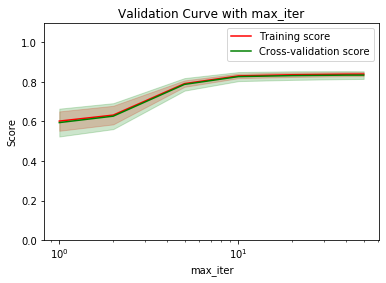

In [44]:
#对逻辑回归的max_iter情况进行查看
train_feat = train_f3.copy()
#grid_plot(train_feat,classifier,3,[10,20,40,80,200,400,800],'n_estimators',param=params)
grid_plot(train_feat,
          'LR',
          3, [1, 2, 5, 10, 20, 40, 50],
          'max_iter',
          param=None)

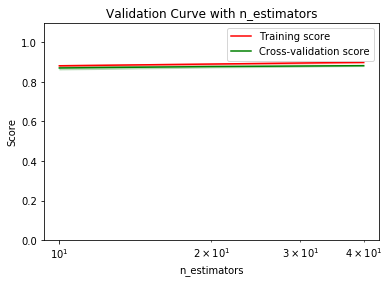

In [45]:
params = {
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'sub_feature': 0.6,
    'num_leaves': 50,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8
}
train_feat = train_f3.copy()
#grid_plot(train_feat,classifier,3,[10,20,40,80,200,400,800],'n_estimators',param=params)
grid_plot(train_feat, 'LGB', 3, [10, 20, 40], 'n_estimators', param=params)

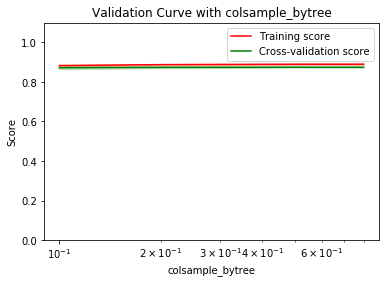

In [46]:
params = {
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 10
}
train_feat = train_f3.copy()
#grid_plot(train_feat,classifier,3,[10,20,40,80,200,400,800],'n_estimators',param=params)
grid_plot(train_feat,
          'LGB',
          3, [0.1, 0.2, 0.5, 0.7, 0.8],
          'colsample_bytree',
          param=params)